# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Prerequisites

### 0.0 Import packages and ModelClass

In [52]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Import data for equivalence scale and life cycle income profile

In [53]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

## 1 Baseline model

In [55]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'thetab':250,
        'K':9,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 54.1 secs
 t = 2 solved in 49.4 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 64.3 secs
 total stay-time  = 9.2 secs
 total ref-time   = 11.4 secs
 total buy-time   = 8.5 secs
 total rent-time   = 10.1 secs
 full model solved in = 103.5 secs
model simulated in 62.0 secs
numba precompiled in 170.7 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.2 secs
 v_bar and q computed in 1.1 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.5 secs
 v_bar and q computed in 1.6 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.7 secs
 v_bar and q computed 

### 1.0 Decision Functions

In [56]:
figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### 1.1 Life Cycle Behaviour

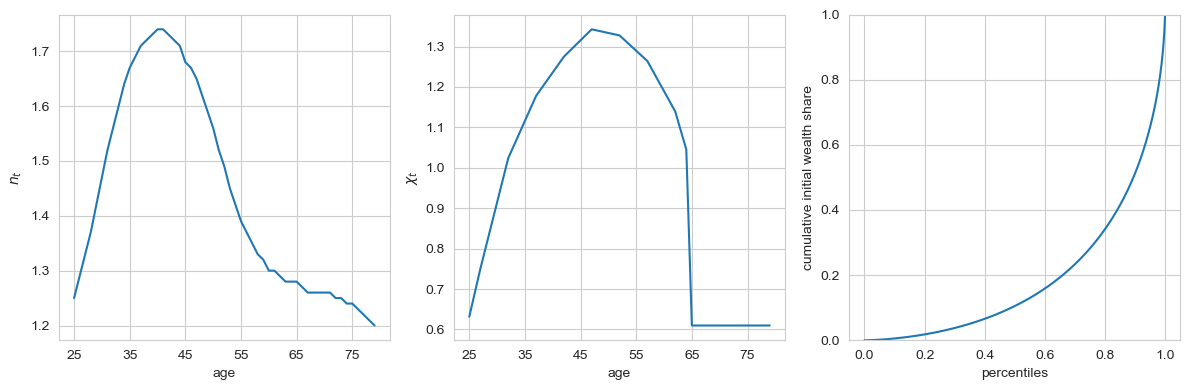

In [61]:
# plot calibration inputs
figs.n_chi_iniwealth(model_baseline,data)

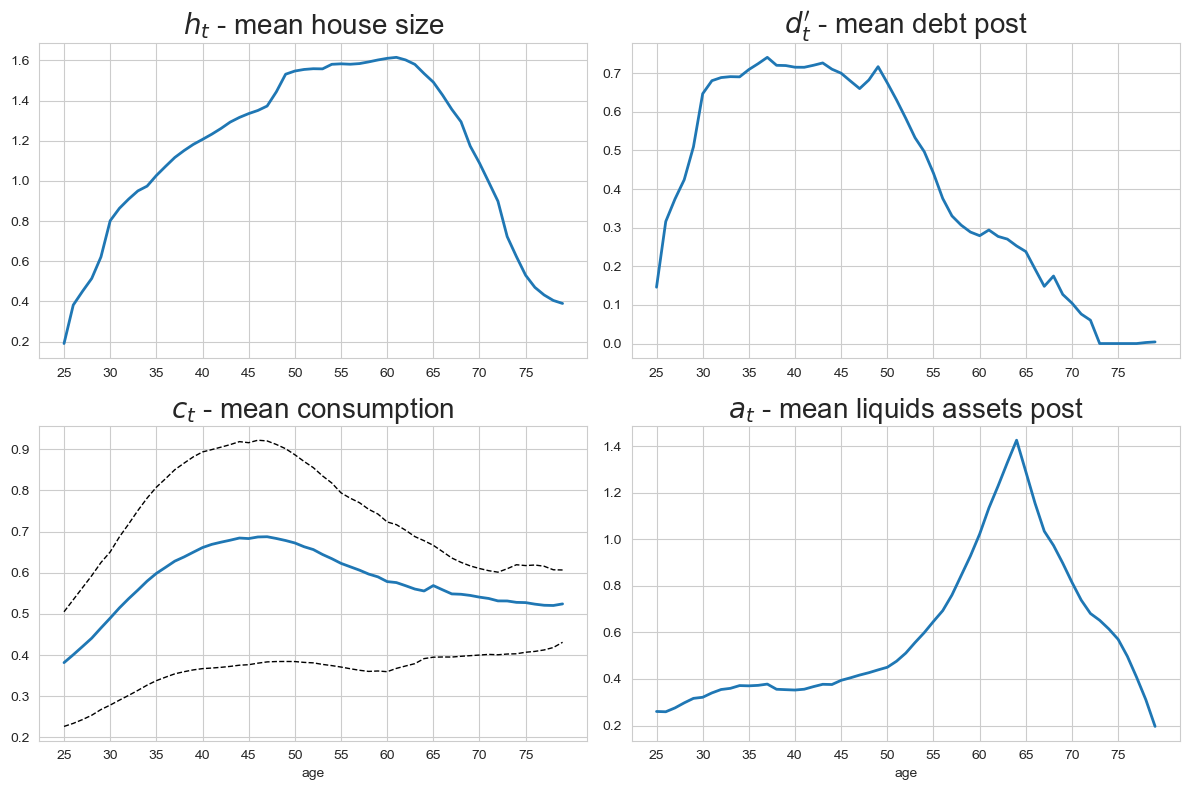

In [62]:
# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Compare with data

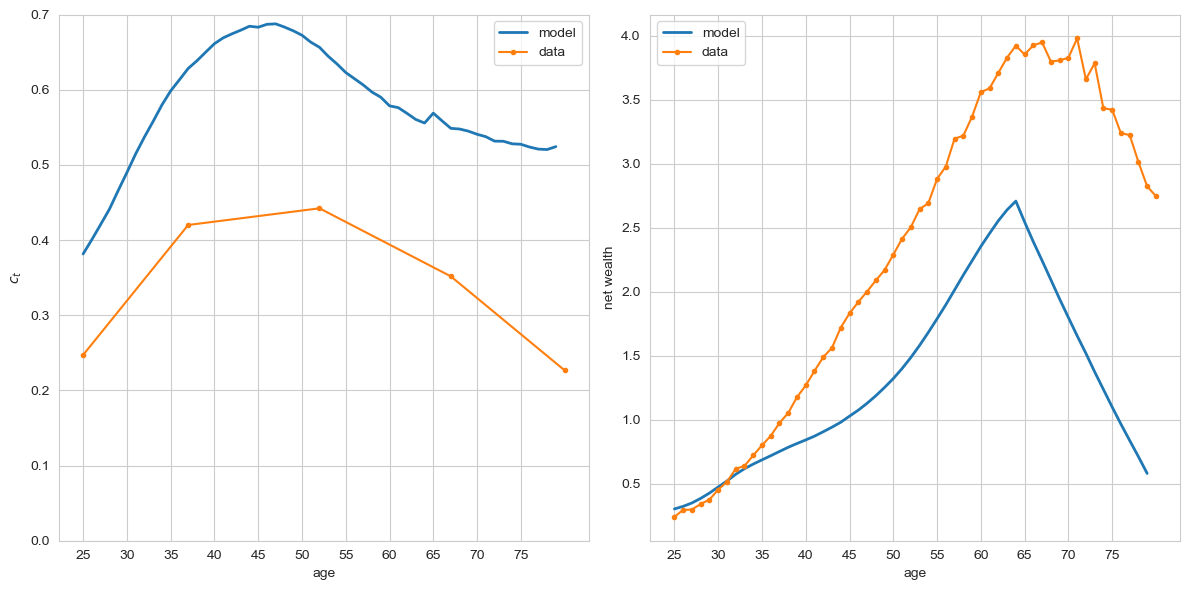

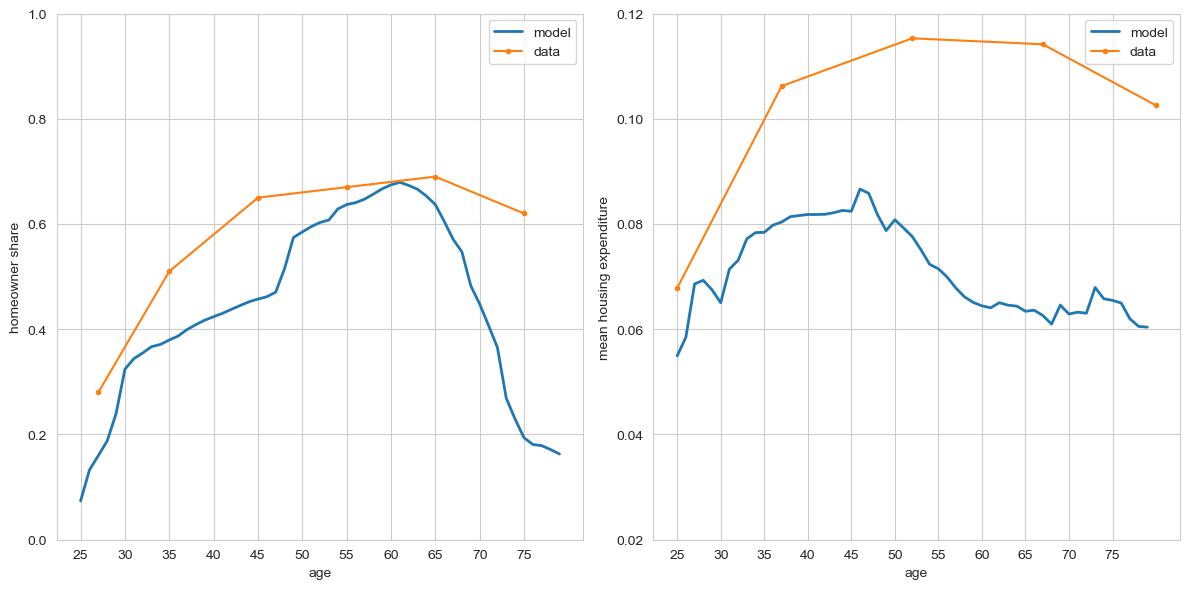

/Users/Christian/Dropbox/KU - Polit/KA/Thesis/MScThesis-2022/figs.py:370: RuntimeWarning: invalid value encountered in true_divide
  DA_shares = np.sum(b_dp_da,axis=1)/np.sum(bool_dp,axis=1)


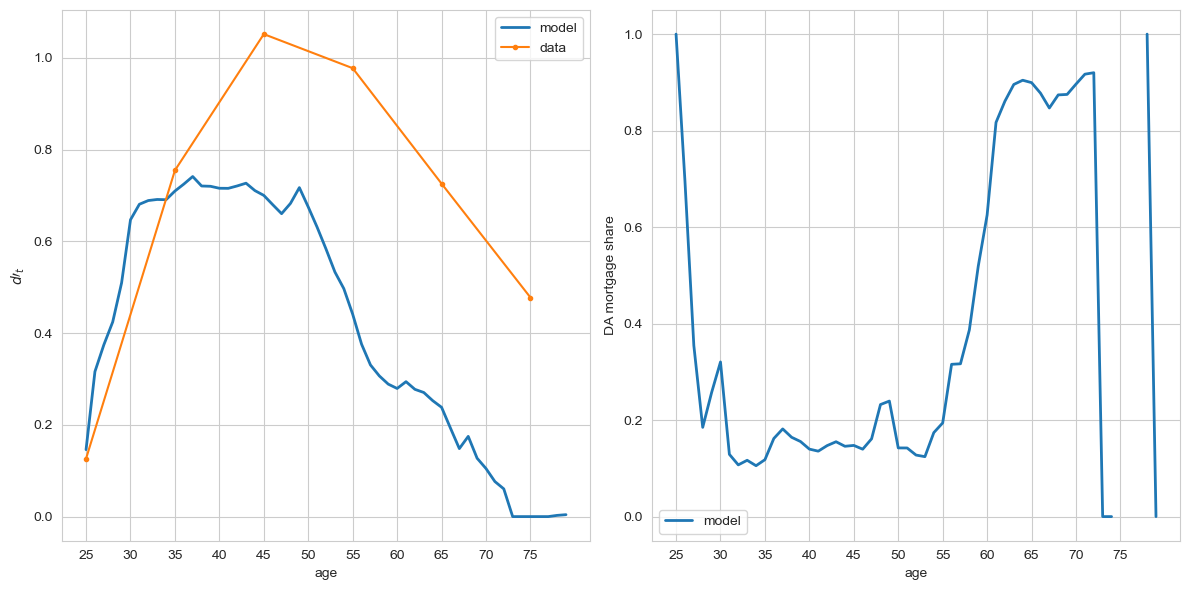

In [63]:
figs.lifecycle_consav(model_baseline)
figs.lifecycle_housing(model_baseline)
figs.lifecycle_mortgage(model_baseline)

### 1.3 Validate simulation

In [64]:
# unpack
sim = model_baseline.sim 
par = model_baseline.par

# validate consumption decision
I = sim.c < 0

print(f'there are {np.sum(I)} cases of negative consumption') 
if np.sum(I) > 0:
    print(f'ref accounts for {np.sum(I*(sim.discrete==1))} and buy for {np.sum(I*(sim.discrete==2))}.')
    print(f'stay accounts for {np.sum(I*(sim.discrete==0))} and rent for {np.sum(I*(sim.discrete==3))}')
    print(f'the share of negative consumption cases is {np.sum(I)/(par.simN*par.T)}')
    print()
    print('negative simulated consumption occurs in periods:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[0])
    print('and cases per period are:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[1])

# assert that there is no uncollateralised debt in the simulation
dp_bool = sim.d_prime>0
hp_bool = sim.h_prime == 0
assert np.sum(dp_bool*hp_bool) == 0, 'there is uncollateralised debt in the simulation'
print('there is no uncollateralised debt in the simulation')

# assert that there is no instances of neither buying nor renting
hp0 = sim.h_prime == 0
ht0 = sim.h_tilde == 0
assert np.sum(hp0*ht0) == 0, f'there are {np.sum(hp0*ht0)} '+'instances of h_t=0 and h^{tilde}_t=0$'
print('there are no instances of neither buying nor renting')

there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting


taxes to labour income is 0.3539
median pre tax income is 0.6097
mean property tax is 0.0109
mean pre tax income is 1.0058


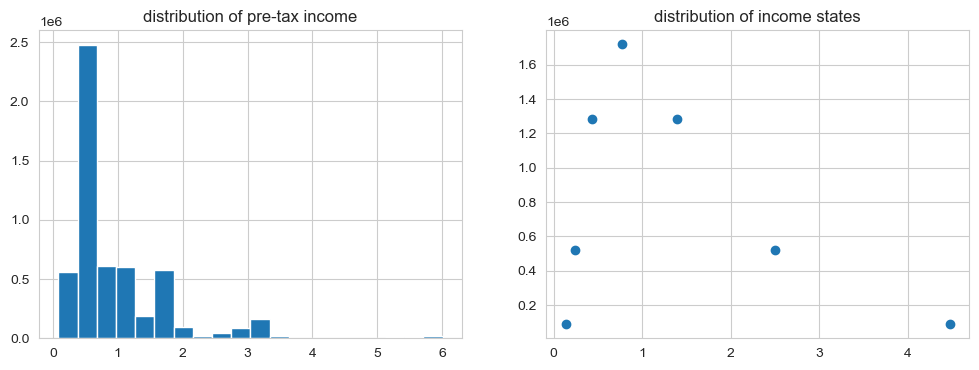

In [65]:
# examine income dynamics and taxation
p = sim.p
y = sim.y
inc_tax = sim.inc_tax
prop_tax = sim.prop_tax
tax_to_inc = np.sum(inc_tax)/np.sum(y)
print(f'taxes to labour income is {tax_to_inc:.4f}')
print(f'median pre tax income is {np.median(y):.4f}')
print(f'mean property tax is {np.mean(prop_tax):.4f}')
print(f'mean pre tax income is {np.mean(y):.4f}')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(y.flatten(),bins=20)
ax1.set_title('distribution of pre-tax income')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(np.unique(p.flatten()),np.unique(p.flatten(),return_counts=True)[1])
ax2.set_title('distribution of income states');


the distribution of house choices is:
[0.   1.42 1.89 2.51 3.34 4.44 5.91]
[3072382  667471  659104  350178  268271  387137   95457]

the distribution of rental choices is:
[0.   1.07 1.42 1.89]
[2427618 2301292  451398  319692]

mean homeowner share is 0.4414


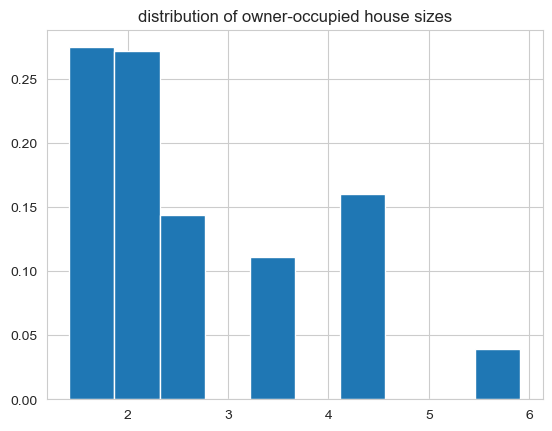

In [66]:
# examine housing and rental decisions
print('the distribution of house choices is:')
print(np.unique(sim.h_prime,return_counts=True)[0])
print(np.unique(sim.h_prime,return_counts=True)[1])
print()
print('the distribution of rental choices is:')
print(np.unique(sim.h_tilde,return_counts=True)[0])
print(np.unique(sim.h_tilde,return_counts=True)[1])
print()

print(f'mean homeowner share is {np.unique(sim.h_tilde,return_counts=True)[1][0]/(par.T*par.simN):.4f}')
h_bool = sim.h > 0 
h = sim.h[h_bool]
plt.hist(h.flatten(),weights=np.ones_like(h.flatten())/len(h.flatten()))
plt.title('distribution of owner-occupied house sizes');

In [70]:
# check for errors in housing stock
bool_buy = sim.discrete == 2
bool_stay = sim.discrete == 0
bool_ref = sim.discrete == 1
bool_rent = sim.discrete == 3

print(f'number of buyers with zero housing stock is {np.sum(sim.h_prime[bool_buy] == 0)}')
print(f'number of stayers with zero housing stock is {np.sum(sim.h_prime[bool_stay] == 0)}')
print(f'number of refinancers with zero housing stock is {np.sum(sim.h_prime[bool_ref] == 0)}')
print(f'number of renters with positive housing stock is {np.sum(sim.h_prime[bool_rent] > 0)}')

number of buyers with zero housing stock is 0
number of stayers with zero housing stock is 0
number of refinancers with zero housing stock is 0
number of renters with positive housing stock is 0


In [69]:
# share of buy choices in the model
print(f'the share of buy choices is {np.mean(sim.discrete == 2):.4f}')
print(f'annual share of houses sold is {np.mean(sim.h_prime != sim.h):.4f}')

the share of buy choices is 0.0348
annual share of houses sold is 0.0487


In [71]:
# validate mortage decision
D = sim.d > 0 # take mortgage?
Dp = sim.d_prime > 0
DA = sim.Tda_prime > 0 # choose deferred amortisation?
t_mat = np.outer(np.arange(par.T),np.ones(par.simN))
D_org = Dp*(sim.Td_prime - (par.Td_bar) == t_mat) # boolean for loan originations

print(f'average mortgage size at origination is {np.mean(sim.d_prime[D_org]):.4f}')
print(f'sum of outstanding mortgage balances are {np.sum(sim.d):.4f}')
#print(f'periods where mortgages are issued are {np.where(np.sum(sim.d_prime,axis=1)>0)[0]}')

average mortgage size at origination is 2.0061
sum of outstanding mortgage balances are 2235511.4823


In [72]:
# validate impact of financial regulation
ltv_denom = sim.h_prime[D_org]
ltv_num = sim.d_prime[D_org]
dti_denom = sim.y[D_org]
ltvs = ltv_num/ltv_denom
dtis = ltv_num/dti_denom

print('the distribution of DA periods is:')
print(np.unique(sim.Tda,return_counts=True)[0])
print(np.unique(sim.Tda,return_counts=True)[1])
print(f'and the share of DA mortgages at origination is {np.sum(DA[D_org])/np.sum(Dp[D_org]):.4f}')
print()
print(f'mean LTV is {np.mean(ltvs):.4f} and mean DTI is {np.mean(dtis):.4f} at mortgage origination')

the distribution of DA periods is:
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[5420008   25168   25461    6808    6327    7526    8694       2       3
       3]
and the share of DA mortgages at origination is 1.0000

mean LTV is 0.8146 and mean DTI is 1.2296 at mortgage origination


### 1.4 Inspect discrete choices

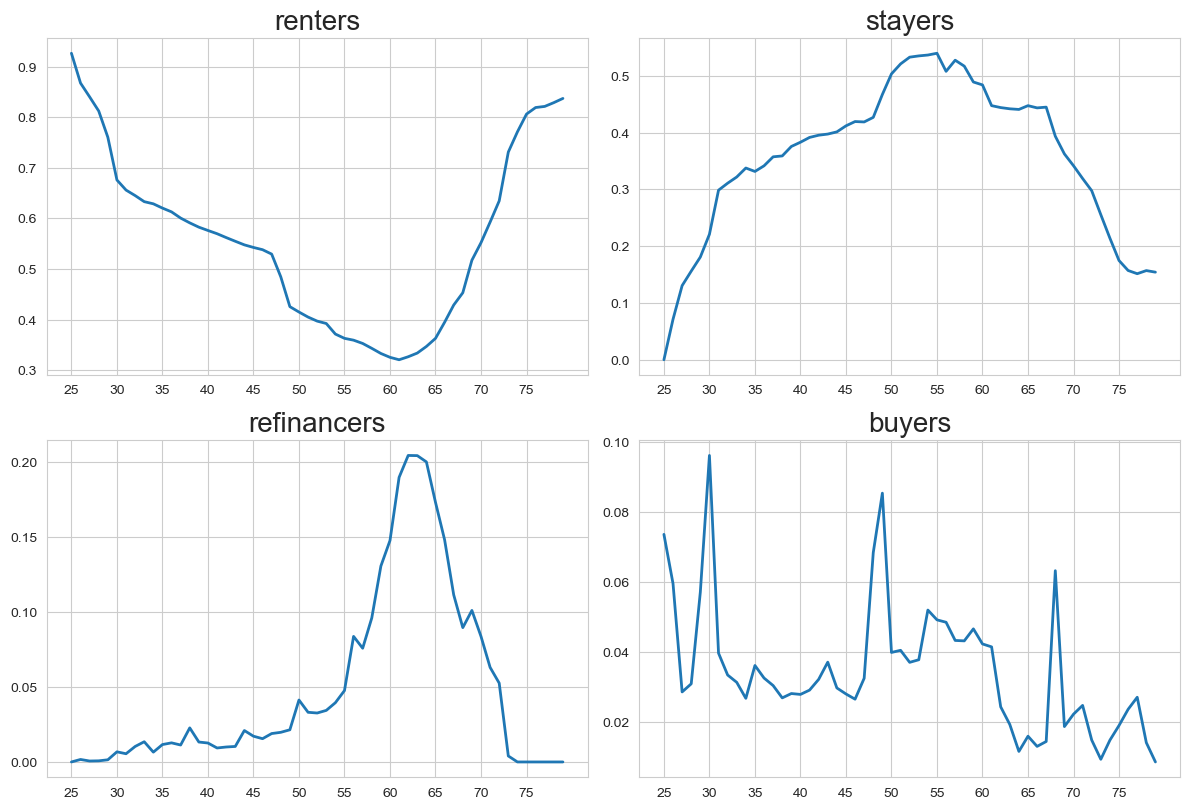

In [73]:
figs.homeownership(model_baseline)

### 1.5 Inspect the life cycle profile of a given household

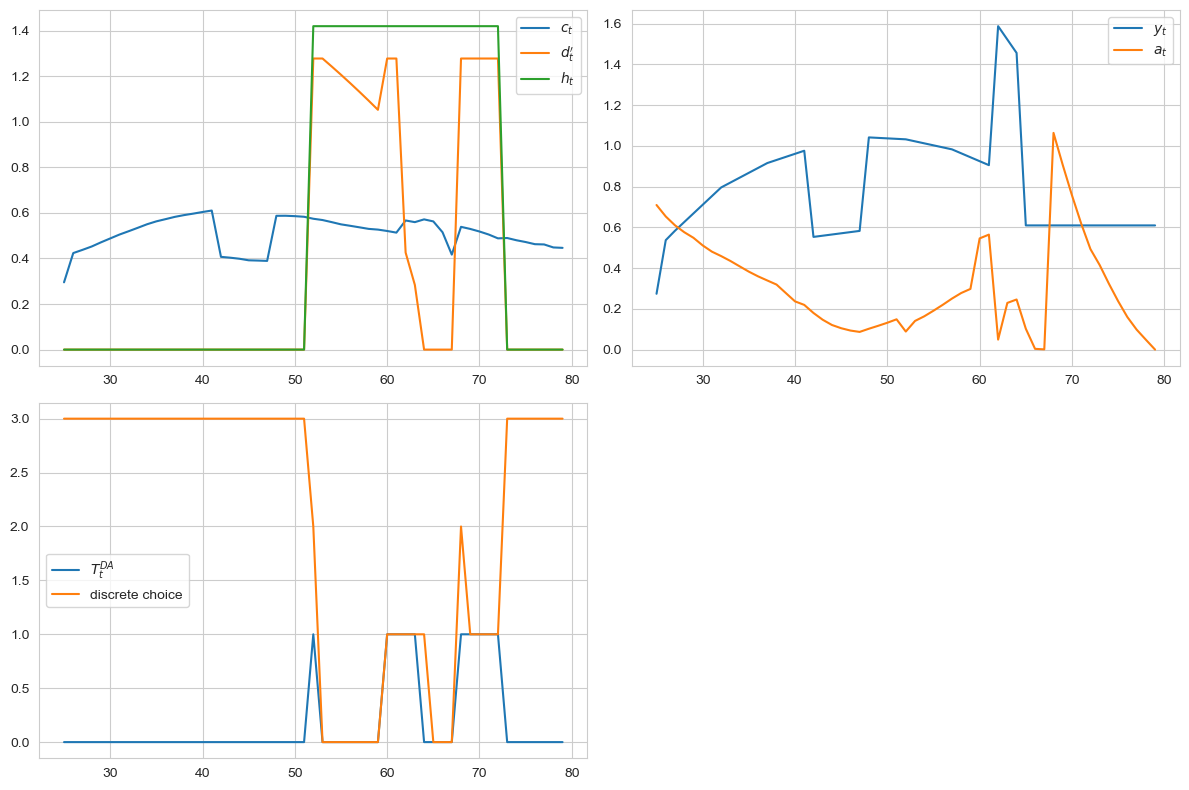

In [74]:
figs.example_household(model_baseline,hh_no=50_000)

### 1.6 Aggregate moments from baseline model

In [75]:
import analyse as ana
names, moments = ana.model_moments(model_baseline)
print('Untargeted moments from baseline model:')
for i in range(len(names)):
    print(f'  {names[i]} = {moments[i]:.4f}')

Untargeted moments from baseline model:
  Homeowner share = 0.4414
  Mean house size = 2.5764
  Average housing expenditure = 0.0711
  Mean mortgage size = 1.6205
  Share of homeowners with mortgage = 0.5841
  DA mortgage share = 0.3024
  Average LTV ratio = 0.7286
  Average DTI ratio = 1.1624
  Gini coefficient = 0.7129


In [76]:
names_targ, moments_targ = ana.model_moments_targ(model_baseline)
print('Targeted moments from baseline model:')
for i in range(len(names_targ)):
    print(f'  {names_targ[i]} = {moments_targ[i]:.4f}')

Targeted moments from baseline model:
  Aggregate net worth / (annual) labour income = 1.2996
  Annual fraction of houses sold = 0.0487
  Home ownership rate of <35 y.o. = 0.2555
  Mean NW at age 75 / mean NW at age 55/50 = 0.6150
  Share of households leaving no bequest = 0.6125


## 2 Model without interest rate deduction

In [ ]:
# consumption equiavalent variation
cev = ana.cev(model_baseline)

### Loop to match bequest level with initial wealth

In [77]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*670_000:.4f}')

initial wealth is 30058.3249
total bequest is 57569.7273
mean bequest is 0.5757
average hh pre-tax income is 673864.9715


In [ ]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')


In [ ]:
from EconModel import jit
import utility

# a. unpack
with jit(model_baseline) as model:
    par = model_baseline.par
    sim = model_baseline.sim 

# b. check utility function
c = 1
h = 1
move = 0 
rent = 1
t = 20
n = par.n[t]
nu = 0.4
alpha = 1.1
s = (1-rent)*h/n + par.phi*rent*h/n
print(f' rent utility is {utility.func(c,h,move,rent,t,par)}')
print(f' own utility is {utility.func(c,h,move,0,t,par)}')
print(f' diff is {utility.func(c,h,move,rent,t,par)-utility.func(c,h,move,0,t,par)}')
print(f' s ={s}')
print(f' u(s) ={nu/(1-alpha)*s**(1-alpha)}')
print(f' u(h) ={nu/(1-alpha)*(h/n)**(1-alpha)}')
print(f' diff is {nu/(1-alpha)*s**(1-alpha)-nu/(1-alpha)*(h/n)**(1-alpha)}')